Author : Jeon, Yeon Ji, jenoyeonji1028@gmail.com

Supervisor : Na, In Seop, ypencil@hanmail.net

Starting Project : 2019.1.4


# 자전거 대여 수요 측정하기
## 데이터 필드
* datetime 
    - 연도-월-일-시간
* season 
    - 1 = 봄, 
    - 2 = 여름
    - 3 = 가을
    - 4 = 겨울 
* holiday 
    - 0 = 공휴일
    - 1= 비공휴일
* workingday
    - 0 = 평일(주말 또는 휴일 아님)
    - 1 = 평일 아님
* weather 
    - 1: 맑음 + 구름 거의 없음 + 구름 약간 
    - 2: 옅은 안개 + 구름 + 구름 약간과 옅은 안개 
    - 3: 가벼운 눈 또는 비 + 가벼운 비 후 개임 + 흐트러진 구름(scattered clouds) 
    - 4: 호우 + 빙판 + 뇌우 + 짙은 안개와 눈 + 짙은 안개
    - 1에서 4로 갈 수록 날씨가 좋지 않다
* temp 
    - 섭씨온도
* atemp
    - 체감온도
* humidity 
    - 습도
* windspeed 
    - 풍속
* casual 
    - 등록되지 않은 비회원의 대여 수
* registered 
    - 등록된 회원의 대여 수
* count 
    - 총 대여 수


## 평가 방식
제출 한 결과들은 RMSLE(Root Mean Squared Logarithmic Error)로 평가한다.
과대평가된 항목보다는, 과소평가된 항목에 패널티를 주는 평가 방식이다. 
값이 적을수록 오류가 적다는 것을 의미한다. 0에 가끼운 값일 수록 정밀도가 높은 값이다.
$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$


## 진행 단계
* 1) 훈련, 테스트 데이터셋 파악
* 2) 데이터 전처리 및 시각화
* 3) 회귀모델 적용
* 4) 결과 데이터셋 생성

## -----------------------------------------------------------------------------------------------------------------------

## 1. 훈련, 테스트 데이터셋 파악

In [1]:
# 필요 라이브러리들 호출

# warning을 무시
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# 데이터 시각화와 실험을 위해
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에 한글이 표시할 수 있기 위해
import platform
path = "c:/Windows/Fonts/HYGPRM.TTF"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 
    
# 그래프에서 마이너스부분이 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 훈련 데이터 셋과 테스트 데이터 셋을 불러온다
# 데이터 전처리 과정 중 datetime을 파싱해야하는 부분이 있어 parse_dates를 넣는다
train = pd.read_csv('../data/train.csv', parse_dates=["datetime"]) 
test = pd.read_csv('../data/test.csv', parse_dates=["datetime"])

# 훈련 데이터 셋을 df로, 테스트 데이터 셋을 test_df로 복사한다
df=train.copy()
test_df=test.copy()

In [3]:
# 훈련 데이터 셋의 개괄적인 모형 파악
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# 훈련 데이터셋의 각 컬럼별 데이터 타입 및 값의 갯수 파악
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [5]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

각 컬럼 모두 비어있는 데이터 없이 모두 10886개의 데이터로 채워져있다

In [6]:
# 테스트 데이터 셋의 개괄적인 형태 출력
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
df.columns.unique()

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

훈련 데이터 셋과 달리, 테스트 데이터 셋에는 casual, registered, count 컬럼이 없다.

## 2. 데이터 전처리 및 시각화

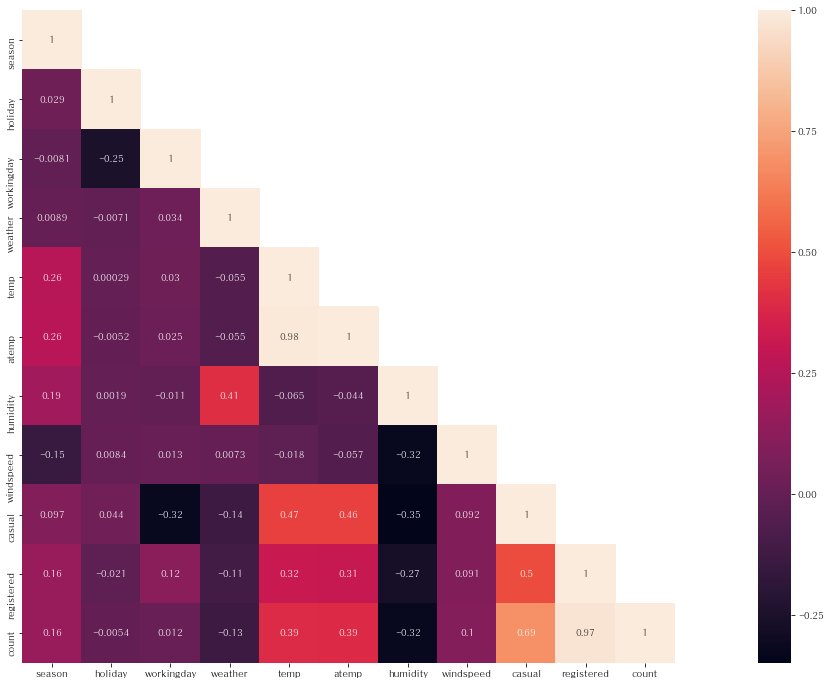

In [8]:
# 데이터 전처리를 진행하기 전에, 각 컬럼간의 연관관계를 시각화로 나타내 보아
# 전처리 필요성을 느껴본다
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

* 검은쪽으로 진할 수록 연관관계가 낮다.
* 자기 자신과의 연관관계는 1이다.
* 온도, 습도, 풍속은 거의 연관관계가 없다. 
* 대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, 테스트 데이터 셋에는 이 값이 없다.
* atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.
* 데이터 전처리를 하지 않은 상태에서 연관관계를 파악하기 힘들다.

### 데이터 전처리 - ① datetime 파싱하기

In [9]:
# 년-월-일-시(hour) 를 분리한다
# 분(minute),초(second) 분리하지 않는 이유는 모든 데이터가 동일하게 0이기 때문이다

df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour

### datetime 시각화

[Text(0.5,0,'hour'), Text(0.5,1,'시간별 대여량')]

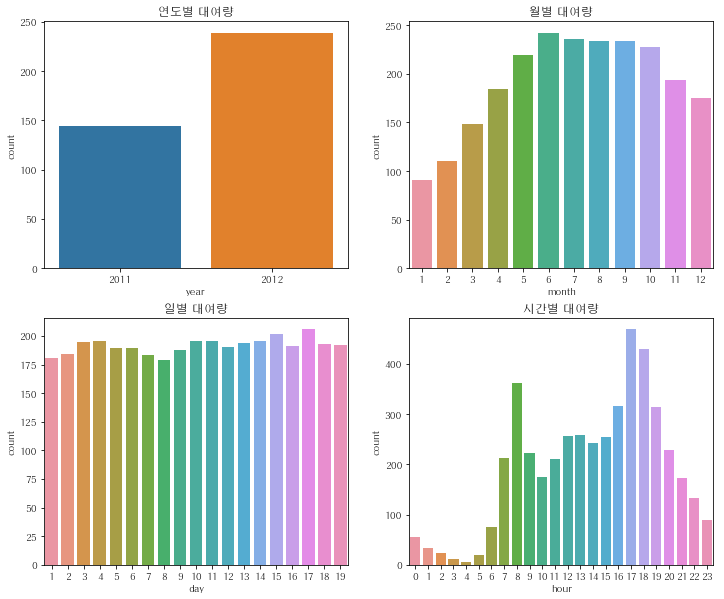

In [10]:
#각각의 속성과 예측의 결과값으로 쓰이는 count값과의 관계 파악

fig = plt.figure(figsize=[12,10])

#년도와 count
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='year',y='count',data=df.groupby('year')['count'].mean().reset_index())
ax1.set(title="연도별 대여량")

#month와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='month',y='count',data=df.groupby('month')['count'].mean().reset_index())
ax2.set(title="월별 대여량")

#day와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='day',y='count',data=df.groupby('day')['count'].mean().reset_index())
ax3.set(title="일별 대여량")

#hour와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='hour',y='count',data=df.groupby('hour')['count'].mean().reset_index())
ax4.set(xlabel='hour', title="시간별 대여량")

- 연도별 대여량 : 2011년 보다 2012년이 더 많이 증가하였다.
- 월별 대여량 : 6월에 가장 많고, 7~10월도 많다. 1월이 가장 적다.
- 일별 대여량 : 1~19일 까지만 데이터가 존재하기 때문에 이 데이터는 피처로 사용할 수 없다.
- 시간별 대여량 : 출퇴근 시간에 가장 많다. 따라서, 주말의 데이터도 나누어 보아야할 것 같다.

### 데이터 전처리 - ② 요일 지정하기

In [11]:
# 요일에 따라 달라질 수 있으므로 컬럼을 추가한다
# 0:일 1:월 2:화 3:수 4:목 5:금 6:토
df["weekday"] = df["datetime"].dt.dayofweek 

In [12]:
# 추가한 컬럼들을 확인해본다
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


### 요일 (weekday) 시각화

[Text(0.5,1,'요일별 대여량')]

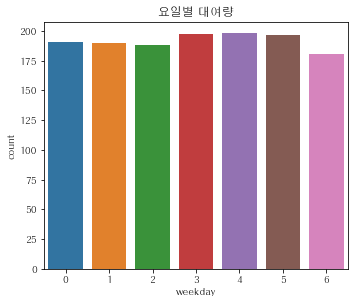

In [13]:
#요일과 count
fig = plt.figure(figsize=[12,10])

ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='weekday',y='count',data=df.groupby('weekday')['count'].mean().reset_index())
ax1.set(title="요일별 대여량")

* 요일별 대여량 : 서로 비슷한 대여량을 보이는데, 수,목,금요일이 가장 많고, 토요일이 가장 적다.

### 데이터 전처리 - ③ season 데이터 수정하기

In [14]:
# season에 이상이 있어 전처리

# 1월의 데이터에서 season 컬럼이 1, 즉 봄으로 나타나있다
# 데이터는 미국 워싱턴의 데이터로, 계절 변화가 우리나라와 비슷하다
# 따라서 1월은 겨울이므로 4, 즉 겨울로 바꿔야한다

def wrongSeason(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

df['season'] = df.month.apply(wrongSeason)

# 훈련 데이터셋을 출력한다
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


### 계절, 날씨, 근무일, 휴일 시각화

[Text(0.5,1,'휴일 여부별 대여량')]

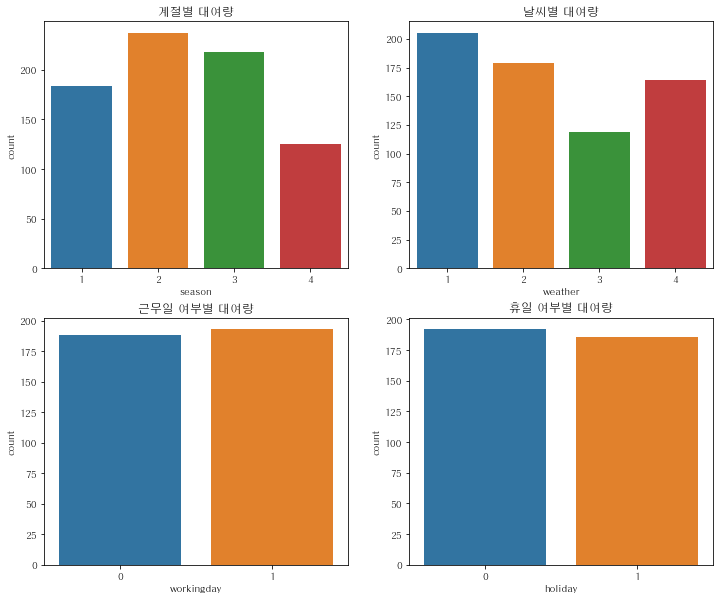

In [15]:
# 계절과 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=df.groupby('season')['count'].mean().reset_index())
ax1.set(title="계절별 대여량")

# 날씨와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='weather',y='count',data=df.groupby('weather')['count'].mean().reset_index())
ax2.set(title="날씨별 대여량")

# 근무일 여부와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=df.groupby('workingday')['count'].mean().reset_index())
ax3.set(title="근무일 여부별 대여량")

# 휴일 여부와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='holiday',y='count',data=df.groupby('holiday')['count'].mean().reset_index())
ax4.set(title="휴일 여부별 대여량")


* 계절과 날씨별 대여량은 각각 큰 차이가 보여진다.
* 하지만, 근무일과 휴일 여부별 대여량에는 큰 차이가 보이지 않는다.
* holiiday는 우리나라의 공휴일과 같다. 따라서 공휴일에는 주말이 포함되지 않지만, 근무일이 아니라는 개념에는 휴일과 주말이 포함되기때문에 근무일만 보는 것이 더 단순하다. 또한, 공휴일인지 주말인지로 대여량에 연관을 줄 것 같지 않아 보인다.

### 시간 - 계절, 날씨, 근무일 여부, 요일에 따른 count 시각화

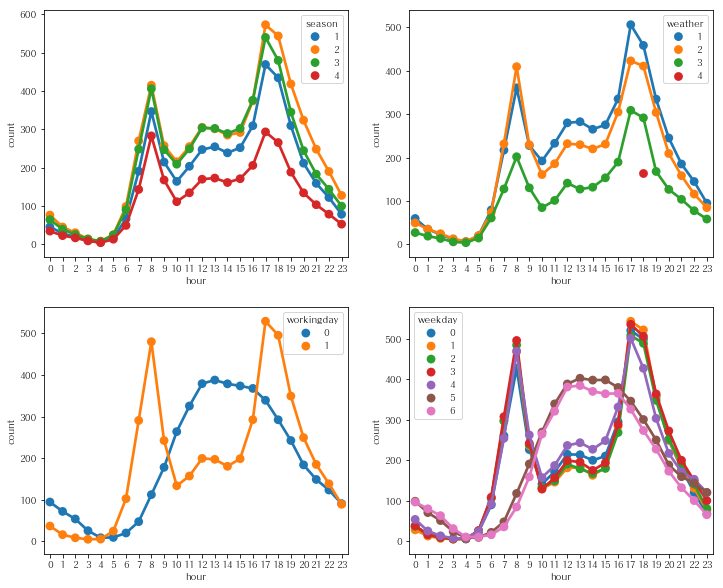

In [16]:
# 시간과 계절에 따른 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.pointplot(x='hour',y='count',hue='season',data=df.groupby(['season','hour'])['count'].mean().reset_index())

# 시간과 날씨에 따른 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.pointplot(x='hour',y='count',hue='weather',data=df.groupby(['weather','hour'])['count'].mean().reset_index())

# 시간과 근무일 여부에 따른 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.pointplot(x='hour',y='count',hue='workingday',data=df.groupby(['workingday','hour'])['count'].mean().reset_index())

# 시간과 요일에 따른 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.pointplot(x='hour',y='count',hue='weekday',data=df.groupby(['weekday','hour'])['count'].mean().reset_index())


- 계절별 대여량 : 여름과 가을에 가장 대여량이 많고, 겨울에 가장 대여량이 적다.
- 날씨별 대여량 : 날씨가 안좋을 수록 대여량이 적다. 가장 좋지 않은 날씨(4)는 드물어 하나의 점으로만 표시되었다.
- 근무일 여부별 대여량 : 근무일인 경우, 대여량이 출근시간(7-8시)와 퇴근시간(17-18시)가 가장 많았다. 근무일이 아닌 경우, 대여량이 점심시간(12-13시)가 가장 많았다.
- 요일별 대여량 : 근무일 여부별 대여량과 매우 흡사한 양상이 보여졌다. 

### 데이터 전처리 - ④ season 데이터 별로 컬럼 추가하기

In [17]:
# 4개의 컬럼을 추가하여 각 계절에 해당하는 컬럼에 1로 표현하고, 아닐 시 0로 표현한다
season=pd.get_dummies(df['season'],prefix='season')
df=pd.concat([df,season],axis=1)

### 데이터 전처리 - ⑤ weather 데이터 별로 컬럼 추가하기

In [18]:
# 4개의 컬럼을 추가하여 각 날씨에 해당하는 컬럼에 1로 표현하고, 아닐 시 0로 표현한다
weather=pd.get_dummies(df['weather'],prefix='weather')
df=pd.concat([df,weather],axis=1)

In [19]:
##추가된 컬럼 확인해보기 위해 훈련 데이터셋 출력
df.drop('season',axis=1,inplace=True)
df.drop('weather',axis=1,inplace=True)
df.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,...,hour,weekday,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,...,0,5,0,0,0,1,1,0,0,0
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,...,1,5,0,0,0,1,1,0,0,0
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,...,2,5,0,0,0,1,1,0,0,0
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,...,3,5,0,0,0,1,1,0,0,0
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,0,1,1,...,4,5,0,0,0,1,1,0,0,0


### 온도, 체감온도, 풍속, 습도에 따른 count 시각화

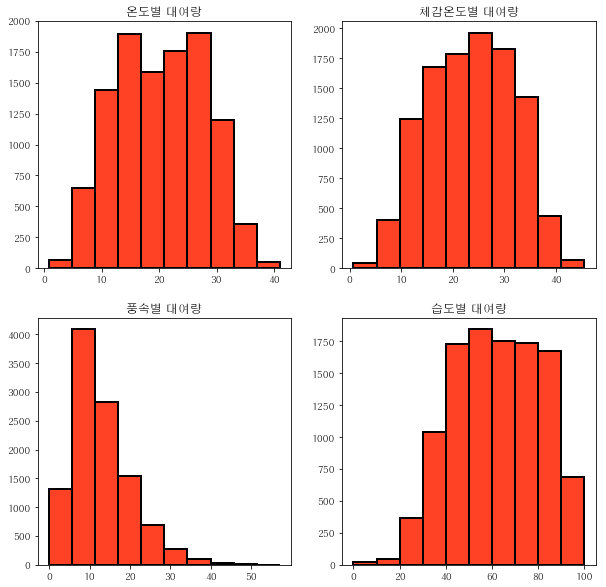

In [20]:
# 다른 컬럼들과 count와 비교

train.temp.unique()
fig,axes=plt.subplots(2,2)

# 온도와 count
axes[0,0].hist(x="temp",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("온도별 대여랑")
# 체감온도와 count
axes[0,1].hist(x="atemp",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("체감온도별 대여량")
# 풍속과 count
axes[1,0].hist(x="windspeed",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("풍속별 대여량")
# 습도와 count
axes[1,1].hist(x="humidity",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("습도별 대여량")
fig.set_size_inches(10,10)

* 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

### 데이터 전처리 - ⑦ windspeed가 0인 데이터 처리하기
* 머신 러닝(랜덤 포레스트 모델)으로 예측 하여 해결한다

In [21]:
# 랜덤 포레스트 모델 import
from sklearn.ensemble import RandomForestRegressor

In [22]:
# 하나의 데이터를 windspeed가 0인 그리고 0이 아닌 데이터프레임으로 분리

# windspeed가 0인 데이터 프레임
Wind0 = df[df['windspeed']==0]
# windspeed가 0이 아닌 데이터 프레임
WindNot0 = df[df['windspeed']!=0]

In [23]:
# windspeed가 0인 데이터 프레임에 투입을 원치 않는 컬럼을 배제
Wind0_df = Wind0.drop(['casual','registered','count','holiday','windspeed','datetime'],axis=1)

In [24]:
# windspeed가 0이 아닌 데이터 프레임은 위와 동일한 데이터프레임을 형성하고
WindNot0_df = WindNot0.drop(['casual','registered','count','holiday','windspeed','datetime'],axis=1)

# 학습시킬 windspeed series를 그대로 둠
WindNot0_series = WindNot0['windspeed']

In [25]:
# 모델에 0이 아닌 데이터프레임과 결과값을 학습
rf = RandomForestRegressor()
rf.fit(WindNot0_df,WindNot0_series)

# 학습된 모델에 Windspeed가 0인 데이터프레임의 windspeed를 도출
predicted_Wind0 = rf.predict(Wind0_df)

In [26]:
# 도출된 값을 원래의 데이터프레임에 넣음
Wind0['windspeed'] = predicted_Wind0

In [27]:
#나눈 데이터 프레임을 원래의 형태로 복원
df = pd.concat([Wind0,WindNot0],axis=0)

In [28]:
#시간별 정렬을 위해 string type의 datetime을 datetime으로 변환
df.datetime = pd.to_datetime(df.datetime,errors='coerce')

In [29]:
#합쳐진 데이터를 datetime순으로 정렬
df = df.sort_values(by=['datetime'])

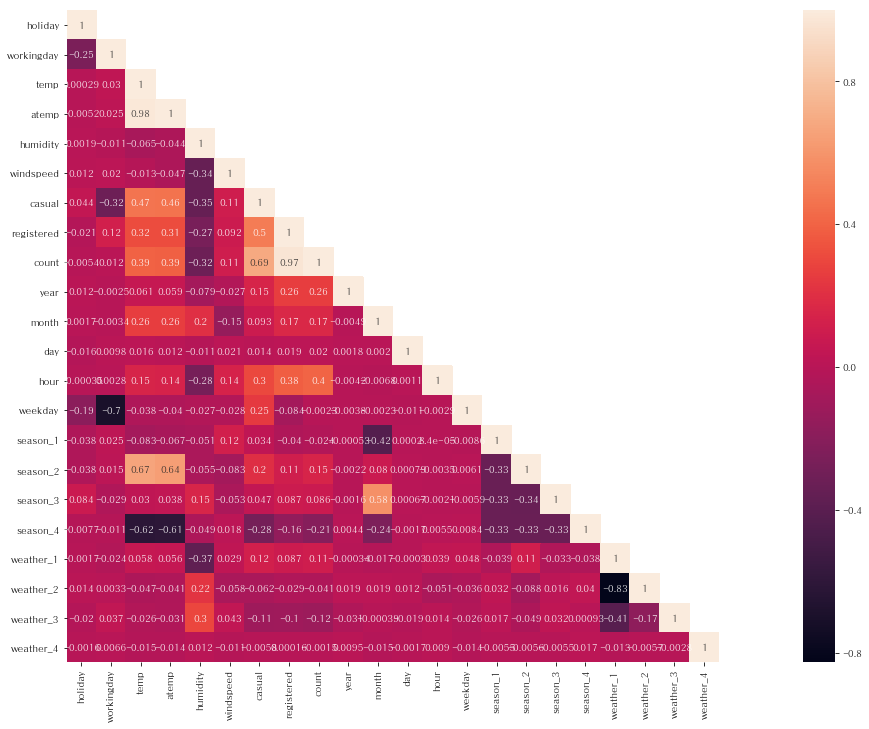

In [30]:
#windspeed를 수정한 후 다시 상관계수를 분석
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

* 기대와는 달리 windspeed와 count의 상관관계는 0.1에서 0.11로 간소한 차이만 보였다

### 동일한 전처리 과정을 테스트셋에도 진행

In [31]:
# 위에서 처리한 데이터 프레임을 훈련 셋으로 한다
train = df

In [32]:
# datetime 파싱하기
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour

In [33]:
# 요일 지정하기
test["weekday"] = test["datetime"].dt.dayofweek 

In [34]:
# season 데이터 수정하기
test['season'] = test.month.apply(wrongSeason)

In [35]:
# season 데이터 별로 컬럼 추가하기
season=pd.get_dummies(test['season'],prefix='season')
test=pd.concat([test,season],axis=1)

In [36]:
# weather 데이터 별로 컬럼 추가하기
weather=pd.get_dummies(test['weather'],prefix='weather')
test=pd.concat([test,weather],axis=1)

In [37]:
# 전처리를 끝냈기 때문에 원래의 컬럼 삭제
test.drop('season',axis=1,inplace=True)
test.drop('weather',axis=1,inplace=True)

In [38]:
# 훈련 셋과 테스트 셋을 합친 combine 생성
combine = pd.concat([train,test],axis=0)

In [39]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 23 columns):
atemp         17379 non-null float64
casual        10886 non-null float64
count         10886 non-null float64
datetime      17379 non-null datetime64[ns]
day           17379 non-null int64
holiday       17379 non-null int64
hour          17379 non-null int64
humidity      17379 non-null int64
month         17379 non-null int64
registered    10886 non-null float64
season_1      17379 non-null uint8
season_2      17379 non-null uint8
season_3      17379 non-null uint8
season_4      17379 non-null uint8
temp          17379 non-null float64
weather_1     17379 non-null uint8
weather_2     17379 non-null uint8
weather_3     17379 non-null uint8
weather_4     17379 non-null uint8
weekday       17379 non-null int64
windspeed     17379 non-null float64
workingday    17379 non-null int64
year          17379 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(8), uint8(8)
memory u

* 테스트 셋에는 casual, registered, count 값이 없으므로 값이 다른 컬럼에 비해 적다

In [40]:
# windspeed가 0인 데이터 수정
Wind0_cb = combine[combine['windspeed']==0]
WindNot0_cb = combine[combine['windspeed']!=0]

In [41]:
Wind0_cb_df = Wind0_cb.drop(['casual','registered','count','holiday','windspeed','datetime'],axis=1)
WindNot0_cb_df = WindNot0_cb.drop(['casual','registered','count','holiday','windspeed','datetime'],axis=1)
WindNot0_cb_series = WindNot0_cb['windspeed']

In [42]:
rf2 = RandomForestRegressor()
rf2.fit(WindNot0_cb_df,WindNot0_cb_series)
predicted_Wind0_cb = rf2.predict(Wind0_cb_df)

In [43]:
Wind0_cb['windspeed'] = predicted_Wind0_cb

In [44]:
combine = pd.concat([Wind0_cb,WindNot0_cb],axis=0)

In [45]:
# 연속형 feature와 범주형 feature 
# 값들이 일정하고 정해져있다 => 범주형, 그 반대 => 연속형
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
categorizational_columns = ['holiday','humidity','season_1','season_2','season_3','season_4',
                            'weather_1','weather_2','weather_3','weather_4',
                            'weekday', 'workingday','year','month','day','hour']

# 범주형 feature의 type을 category로 변경 해 준다.
# 머신러닝 모델에 훈련시킬 때는 문자열 값은 불가능하기 때문에 문자열을 카테고리화 하고 각각에 해당하는 값을 숫자로 변환해준다
for col in categorizational_columns:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

### 피처 선정

In [46]:
# 피처를 선정함
feature_col = ['season_1','season_2','season_3','season_4',
                 'weather_1','weather_2','weather_3','weather_4',
                 'weekday','atemp', 'humidity', 'windspeed',
                 'year', 'month', 'day', 'hour','workingday']

In [47]:
# 피처만을 가지는 셋을 만들고
# 이 셋들은 랜덤포레스트의 학습과 예측에 사용된다

train_data = train[feature_col]
train_lables = train['count']
test_data = test[feature_col]

## 3. 회귀모델 적용

### KFold 교차검증

* k=5일 경우
![title](../data/20190118_155120.png)


* 테스트를 위한 데이터의 수가 충분하지 않는 경우 사용한다.
* 모든 데이터를 test 데이터 셋으로 만드는 방법으로, KFold 교차검증이란, 데이터 셋을 여러개로 나누어 하나씩 test 데이터 셋으로 사용하고 나머지를 모두 학습용 데이터 셋으로 사용하는 방법이다.

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
# n_splits = 10개로 나눈다

### 랜덤 포레스트

In [49]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### 평가 ( RMSLE 방식 )

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$


In [50]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [51]:
%time score = cross_val_score(model, train_data, train_lables, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

Wall time: 17.1 s
Score= 0.32262


In [52]:
# 학습시킴, 피팅 - 피처(train_data)와 레이블(train_lables)을 넣어주면 알아서 학습을 함
model.fit(train_data, train_lables)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [53]:
# 예측
predictions = model.predict(test_data)

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0.5,1,'test')]

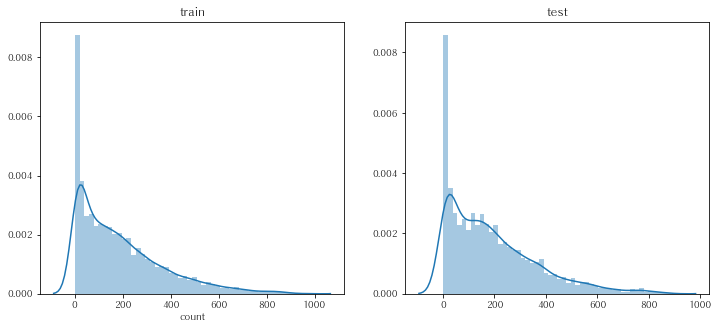

In [54]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(train_lables,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

## 4. 결과 데이터셋 생성

In [55]:
submission = pd.read_csv("../data/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.62
1,2011-01-20 01:00:00,6.49
2,2011-01-20 02:00:00,5.83
3,2011-01-20 03:00:00,3.52
4,2011-01-20 04:00:00,3.07


In [56]:
submission.to_csv("../data/Score_{0:.5f}_submission.csv".format(score), index=False)